In [1]:
import flair
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from flair.data import Sentence
from flair.models import SequenceTagger

# make a sentence
sentence = Sentence('I love Berlin .')

# load the NER tagger
tagger = SequenceTagger.load('ner')

# run NER over sentence
tagger.predict(sentence)

2020-03-18 16:27:57,136 loading file /home/qingpeng/.flair/models/en-ner-conll03-v0.4.pt


[Sentence: "I love Berlin ." - 4 Tokens]

In [3]:
print(sentence)
print('The following NER tags are found:')

# iterate over entities and print
for entity in sentence.get_spans('ner'):
    print(entity)

Sentence: "I love Berlin ." - 4 Tokens
The following NER tags are found:
LOC-span [3]: "Berlin"


In [4]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# define columns
columns = {0: 'text', 1: '_', 2:'_', 3: 'ner'}

# this is the folder in which train, test and dev files reside
data_folder = './data' # /path/to/data/folder

# init a corpus using column format, data folder and the names of the train, dev and test files
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='valid.txt')

2020-03-18 16:28:03,829 Reading data from data
2020-03-18 16:28:03,831 Train: data/train.txt
2020-03-18 16:28:03,833 Dev: data/valid.txt
2020-03-18 16:28:03,834 Test: data/test.txt


In [5]:
print(corpus)
# train 14041
# test 3453
# valid 3250

Corpus: 14041 train + 3250 dev + 3453 test sentences


In [6]:
len(corpus.train)

14041

In [7]:
print(corpus.test[0].to_tagged_string('ner'))

SOCCER - JAPAN <B-LOC> GET LUCKY WIN , CHINA <B-PER> IN SURPRISE DEFEAT .


In [8]:
# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)

Dictionary with 12 tags: <unk>, O, B-ORG, B-MISC, B-PER, I-PER, B-LOC, I-ORG, I-MISC, I-LOC, <START>, <STOP>


In [9]:
from flair.embeddings import ELMoEmbeddings
from flair.embeddings import BertEmbeddings

# sentence = corpus.test[0]
sentence = Sentence('The grass is green .')
print(sentence)

# init embedding
# elmo_embedding = ELMoEmbeddings("small")
bert_embedding = BertEmbeddings()

# just embed a sentence using the StackedEmbedding as you would with any single embedding.
# elmo_embedding.embed(sentence)
bert_embedding.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding)

Sentence: "The grass is green ." - 5 Tokens



Token: 1 The
tensor([-0.0323, -0.3904, -1.1946,  ...,  0.1305, -0.1365, -0.4323],
       device='cuda:0')
Token: 2 grass
tensor([-0.3973,  0.2652, -0.1337,  ...,  0.3715,  0.1097, -1.1625],
       device='cuda:0')
Token: 3 is
tensor([ 0.1374, -0.3688, -0.8292,  ...,  0.2533,  0.0294,  0.4293],
       device='cuda:0')
Token: 4 green
tensor([-0.7722, -0.1152,  0.3661,  ...,  0.1575, -0.0682, -0.7661],
       device='cuda:0')
Token: 5 .
tensor([ 0.1441, -0.1772, -0.5911,  ..., -1.4830,  0.1995, -0.0112],
       device='cuda:0')


In [10]:
# 4. initialize embeddings
# embeddings: ELMoEmbeddings("small")
    
# 5. initialize sequence tagger
from flair.models import SequenceTagger

tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=bert_embedding,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

In [ ]:
# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

# 7. start training
trainer.train('./log/bert/',
              learning_rate=0.01,
              mini_batch_size=64,
              max_epochs=150)

2020-03-18 16:29:50,371 ----------------------------------------------------------------------------------------------------
2020-03-18 16:29:50,375 Model: "SequenceTagger(
  (embeddings): BertEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.

2020-03-18 16:29:50,377 ----------------------------------------------------------------------------------------------------
2020-03-18 16:29:50,379 Corpus: "Corpus: 14041 train + 3250 dev + 3453 test sentences"
2020-03-18 16:29:50,380 ----------------------------------------------------------------------------------------------------
2020-03-18 16:29:50,381 Parameters:
2020-03-18 16:29:50,382  - learning_rate: "0.01"
2020-03-18 16:29:50,383  - mini_batch_size: "64"
2020-03-18 16:29:50,384  - patience: "3"
2020-03-18 16:29:50,386  - anneal_factor: "0.5"
2020-03-18 16:29:50,387  - max_epochs: "150"
2020-03-18 16:29:50,387  - shuffle: "True"
2020-03-18 16:29:50,388  - train_with_dev: "False"
2020-03-18 16:29:50,391  - batch_growth_annealing: "False"
2020-03-18 16:29:50,391 ----------------------------------------------------------------------------------------------------
2020-03-18 16:29:50,392 Model training base path: "log/bert"
2020-03-18 16:29:50,393 --------------------------------

2020-03-18 16:42:01,460 epoch 6 - iter 110/220 - loss 1.57393092 - samples/sec: 441.64
2020-03-18 16:42:20,881 epoch 6 - iter 132/220 - loss 1.57410415 - samples/sec: 513.84
2020-03-18 16:42:40,386 epoch 6 - iter 154/220 - loss 1.57089043 - samples/sec: 443.43
2020-03-18 16:42:59,749 epoch 6 - iter 176/220 - loss 1.56712897 - samples/sec: 452.44
2020-03-18 16:43:18,767 epoch 6 - iter 198/220 - loss 1.55955757 - samples/sec: 451.52
2020-03-18 16:43:38,215 epoch 6 - iter 220/220 - loss 1.55088001 - samples/sec: 452.47
2020-03-18 16:43:54,568 ----------------------------------------------------------------------------------------------------
2020-03-18 16:43:54,570 EPOCH 6 done: loss 1.5509 - lr 0.0100
2020-03-18 16:43:57,803 DEV : loss 1.0452550649642944 - score 0.8984
2020-03-18 16:43:57,897 BAD EPOCHS (no improvement): 0
2020-03-18 16:44:03,877 ----------------------------------------------------------------------------------------------------
2020-03-18 16:44:07,063 epoch 7 - iter 22/

2020-03-18 17:03:44,502 epoch 12 - iter 220/220 - loss 1.14912778 - samples/sec: 532.49
2020-03-18 17:04:00,258 ----------------------------------------------------------------------------------------------------
2020-03-18 17:04:00,260 EPOCH 12 done: loss 1.1491 - lr 0.0100
2020-03-18 17:04:03,504 DEV : loss 0.8463948369026184 - score 0.9155
2020-03-18 17:04:03,598 BAD EPOCHS (no improvement): 0
2020-03-18 17:04:09,426 ----------------------------------------------------------------------------------------------------
2020-03-18 17:04:12,605 epoch 13 - iter 22/220 - loss 1.07344465 - samples/sec: 444.02
2020-03-18 17:04:31,370 epoch 13 - iter 44/220 - loss 1.16138288 - samples/sec: 444.35
2020-03-18 17:04:48,981 epoch 13 - iter 66/220 - loss 1.17173357 - samples/sec: 427.54
2020-03-18 17:05:08,208 epoch 13 - iter 88/220 - loss 1.14430181 - samples/sec: 446.34
2020-03-18 17:05:27,005 epoch 13 - iter 110/220 - loss 1.14178916 - samples/sec: 532.40
2020-03-18 17:05:45,149 epoch 13 - iter

2020-03-18 17:23:19,794 BAD EPOCHS (no improvement): 3
2020-03-18 17:23:25,716 ----------------------------------------------------------------------------------------------------
2020-03-18 17:23:28,837 epoch 19 - iter 22/220 - loss 0.97095120 - samples/sec: 452.18
2020-03-18 17:23:47,544 epoch 19 - iter 44/220 - loss 0.98010149 - samples/sec: 527.44
2020-03-18 17:24:05,460 epoch 19 - iter 66/220 - loss 0.95429459 - samples/sec: 444.66
2020-03-18 17:24:23,178 epoch 19 - iter 88/220 - loss 0.93931630 - samples/sec: 428.78
2020-03-18 17:24:42,108 epoch 19 - iter 110/220 - loss 0.94588413 - samples/sec: 458.29
2020-03-18 17:25:01,517 epoch 19 - iter 132/220 - loss 0.94358108 - samples/sec: 443.36
2020-03-18 17:25:20,166 epoch 19 - iter 154/220 - loss 0.94675025 - samples/sec: 518.16
2020-03-18 17:25:39,989 epoch 19 - iter 176/220 - loss 0.95228039 - samples/sec: 444.64
2020-03-18 17:25:59,436 epoch 19 - iter 198/220 - loss 0.95502932 - samples/sec: 440.65
2020-03-18 17:26:18,974 epoch 19

2020-03-18 17:43:39,709 epoch 25 - iter 66/220 - loss 0.83542200 - samples/sec: 454.62
2020-03-18 17:43:59,055 epoch 25 - iter 88/220 - loss 0.83150532 - samples/sec: 450.00
2020-03-18 17:44:18,094 epoch 25 - iter 110/220 - loss 0.83024774 - samples/sec: 459.64
2020-03-18 17:44:37,475 epoch 25 - iter 132/220 - loss 0.83732332 - samples/sec: 440.85
2020-03-18 17:44:56,223 epoch 25 - iter 154/220 - loss 0.82190746 - samples/sec: 456.33
2020-03-18 17:45:15,223 epoch 25 - iter 176/220 - loss 0.83100253 - samples/sec: 436.63
2020-03-18 17:45:34,447 epoch 25 - iter 198/220 - loss 0.82169252 - samples/sec: 454.48
2020-03-18 17:45:54,171 epoch 25 - iter 220/220 - loss 0.81519775 - samples/sec: 452.85
2020-03-18 17:46:10,157 ----------------------------------------------------------------------------------------------------
2020-03-18 17:46:10,158 EPOCH 25 done: loss 0.8152 - lr 0.0100
2020-03-18 17:46:13,411 DEV : loss 0.723145604133606 - score 0.9269
2020-03-18 17:46:13,506 BAD EPOCHS (no imp

2020-03-18 18:04:21,330 epoch 31 - iter 154/220 - loss 0.73043122 - samples/sec: 431.82
2020-03-18 18:04:39,488 epoch 31 - iter 176/220 - loss 0.73038076 - samples/sec: 446.23
2020-03-18 18:04:58,372 epoch 31 - iter 198/220 - loss 0.72265509 - samples/sec: 451.02
2020-03-18 18:05:17,904 epoch 31 - iter 220/220 - loss 0.71606467 - samples/sec: 447.41
2020-03-18 18:05:34,131 ----------------------------------------------------------------------------------------------------
2020-03-18 18:05:34,132 EPOCH 31 done: loss 0.7161 - lr 0.0100
2020-03-18 18:05:37,380 DEV : loss 0.6892886757850647 - score 0.932
2020-03-18 18:05:37,474 BAD EPOCHS (no improvement): 0
2020-03-18 18:05:43,534 ----------------------------------------------------------------------------------------------------
2020-03-18 18:05:46,624 epoch 32 - iter 22/220 - loss 0.75151855 - samples/sec: 456.80
2020-03-18 18:06:04,803 epoch 32 - iter 44/220 - loss 0.74110248 - samples/sec: 437.85
2020-03-18 18:06:23,745 epoch 32 - ite

2020-03-18 18:24:44,867 epoch 37 - iter 220/220 - loss 0.62110951 - samples/sec: 484.69
2020-03-18 18:25:00,619 ----------------------------------------------------------------------------------------------------
2020-03-18 18:25:00,621 EPOCH 37 done: loss 0.6211 - lr 0.0050
2020-03-18 18:25:03,897 DEV : loss 0.6618233919143677 - score 0.9314
2020-03-18 18:25:03,992 BAD EPOCHS (no improvement): 1
2020-03-18 18:25:04,002 ----------------------------------------------------------------------------------------------------
2020-03-18 18:25:07,142 epoch 38 - iter 22/220 - loss 0.64036598 - samples/sec: 449.35
2020-03-18 18:25:26,637 epoch 38 - iter 44/220 - loss 0.61680887 - samples/sec: 431.53
2020-03-18 18:25:46,009 epoch 38 - iter 66/220 - loss 0.61355778 - samples/sec: 439.14
2020-03-18 18:26:05,440 epoch 38 - iter 88/220 - loss 0.62197692 - samples/sec: 456.58
2020-03-18 18:26:24,842 epoch 38 - iter 110/220 - loss 0.61621603 - samples/sec: 448.19
2020-03-18 18:26:44,388 epoch 38 - iter

2020-03-18 18:44:13,660 DEV : loss 0.661521852016449 - score 0.9328
2020-03-18 18:44:13,765 BAD EPOCHS (no improvement): 1
2020-03-18 18:44:13,775 ----------------------------------------------------------------------------------------------------
2020-03-18 18:44:16,754 epoch 44 - iter 22/220 - loss 0.56686246 - samples/sec: 473.35
2020-03-18 18:44:34,889 epoch 44 - iter 44/220 - loss 0.54683491 - samples/sec: 455.99
2020-03-18 18:44:53,320 epoch 44 - iter 66/220 - loss 0.57808771 - samples/sec: 430.63
2020-03-18 18:45:11,128 epoch 44 - iter 88/220 - loss 0.57653876 - samples/sec: 512.49
2020-03-18 18:45:30,572 epoch 44 - iter 110/220 - loss 0.58306649 - samples/sec: 436.51
2020-03-18 18:45:50,087 epoch 44 - iter 132/220 - loss 0.58358799 - samples/sec: 438.14
2020-03-18 18:46:09,705 epoch 44 - iter 154/220 - loss 0.58157749 - samples/sec: 451.23
2020-03-18 18:46:29,054 epoch 44 - iter 176/220 - loss 0.57818843 - samples/sec: 445.53
2020-03-18 18:46:48,506 epoch 44 - iter 198/220 - lo

2020-03-18 19:03:30,053 epoch 50 - iter 44/220 - loss 0.53944175 - samples/sec: 444.11
2020-03-18 19:03:49,002 epoch 50 - iter 66/220 - loss 0.57433311 - samples/sec: 527.60
2020-03-18 19:04:08,295 epoch 50 - iter 88/220 - loss 0.58101866 - samples/sec: 455.87
2020-03-18 19:04:27,673 epoch 50 - iter 110/220 - loss 0.57744496 - samples/sec: 452.20
2020-03-18 19:04:46,982 epoch 50 - iter 132/220 - loss 0.56978564 - samples/sec: 451.29
2020-03-18 19:05:06,523 epoch 50 - iter 154/220 - loss 0.56829243 - samples/sec: 442.15
2020-03-18 19:05:25,504 epoch 50 - iter 176/220 - loss 0.56166535 - samples/sec: 445.63
2020-03-18 19:05:43,802 epoch 50 - iter 198/220 - loss 0.55851903 - samples/sec: 446.24
2020-03-18 19:06:02,288 epoch 50 - iter 220/220 - loss 0.55082526 - samples/sec: 446.83
2020-03-18 19:06:17,519 ----------------------------------------------------------------------------------------------------
2020-03-18 19:06:17,521 EPOCH 50 done: loss 0.5508 - lr 0.0013
2020-03-18 19:06:20,786

2020-03-18 19:22:59,187 epoch 56 - iter 110/220 - loss 0.53673674 - samples/sec: 446.64
2020-03-18 19:23:18,476 epoch 56 - iter 132/220 - loss 0.54735540 - samples/sec: 444.68
2020-03-18 19:23:36,670 epoch 56 - iter 154/220 - loss 0.54258335 - samples/sec: 455.02
2020-03-18 19:23:54,709 epoch 56 - iter 176/220 - loss 0.54784041 - samples/sec: 442.03
2020-03-18 19:24:13,589 epoch 56 - iter 198/220 - loss 0.55299534 - samples/sec: 452.92
2020-03-18 19:24:31,591 epoch 56 - iter 220/220 - loss 0.55368269 - samples/sec: 451.93
2020-03-18 19:24:46,905 ----------------------------------------------------------------------------------------------------
2020-03-18 19:24:46,907 EPOCH 56 done: loss 0.5537 - lr 0.0006
2020-03-18 19:24:50,170 DEV : loss 0.6560351848602295 - score 0.935
Epoch    56: reducing learning rate of group 0 to 3.1250e-04.
2020-03-18 19:24:50,265 BAD EPOCHS (no improvement): 4
2020-03-18 19:24:56,207 ---------------------------------------------------------------------------

2020-03-18 19:42:42,704 epoch 62 - iter 176/220 - loss 0.53012533 - samples/sec: 448.98
2020-03-18 19:43:03,376 epoch 62 - iter 198/220 - loss 0.53045438 - samples/sec: 435.89
2020-03-18 19:43:20,919 epoch 62 - iter 220/220 - loss 0.53473228 - samples/sec: 446.97
2020-03-18 19:43:36,268 ----------------------------------------------------------------------------------------------------
2020-03-18 19:43:36,270 EPOCH 62 done: loss 0.5347 - lr 0.0003
2020-03-18 19:43:39,522 DEV : loss 0.6535525321960449 - score 0.9344
2020-03-18 19:43:39,616 BAD EPOCHS (no improvement): 2
2020-03-18 19:43:39,628 ----------------------------------------------------------------------------------------------------
2020-03-18 19:43:42,928 epoch 63 - iter 22/220 - loss 0.66441330 - samples/sec: 427.58
2020-03-18 19:44:00,487 epoch 63 - iter 44/220 - loss 0.59683370 - samples/sec: 532.26
2020-03-18 19:44:19,172 epoch 63 - iter 66/220 - loss 0.59905305 - samples/sec: 441.58
2020-03-18 19:44:37,165 epoch 63 - ite

Weights plots are saved in log/elmo/weights.png


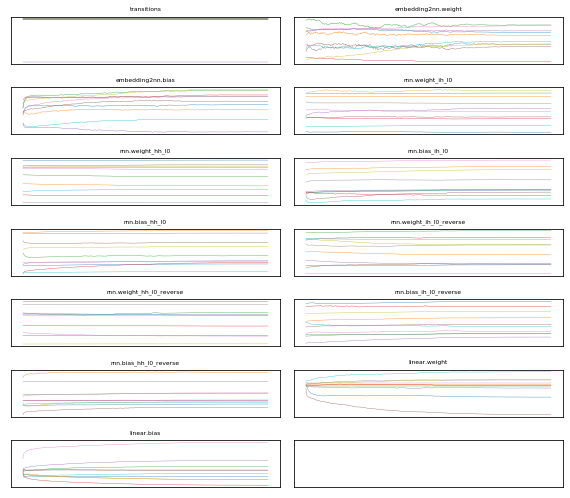

In [22]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('./log/elmo/weights.txt')